In [1]:
%matplotlib inline

# import statements
import numpy as np
import matplotlib.pyplot as plt #for figures
from mpl_toolkits.basemap import Basemap #to render maps
import math
import json #to write dict with parameters

import GrowYourIC
from GrowYourIC import positions, geodyn, geodyn_trg, geodyn_static, plot_data, data

plt.rcParams['figure.figsize'] = (8.0, 3.0) #size of figures
cm = plt.cm.get_cmap('viridis')
cm2 = plt.cm.get_cmap('winter')

In [19]:
age_ic_dim = 1e9 #in years
rICB_dim = 1221. #in km
v_g_dim = rICB_dim/age_ic_dim # in km/years #growth rate
print("Growth rate is {:.2e} km/years".format(v_g_dim))
v_g_dim_seconds = v_g_dim*1e3/(np.pi*1e7)

translation_velocity_dim = 0.8*v_g_dim_seconds
time_translation = rICB_dim*1e3/translation_velocity_dim /(np.pi*1e7)
maxAge = 2.*time_translation/1e6

units = None #we give them already dimensionless parameters. 
rICB = 1.
age_ic = 1.
omega = 0.
omega_2_dim = 0.09 #degree/Myears
omega_2 = omega_2_dim*np.pi/180*age_ic_dim*1e-6

velocity_amplitude = translation_velocity_dim*age_ic_dim*np.pi*1e7/rICB_dim/1e3
velocity_center = [0., 100.]#center of the eastern hemisphere
center = [0,-80] #center of the western hemisphere
velocity = geodyn_trg.translation_velocity(velocity_center, velocity_amplitude)
exponent_growth = 1.

proxy_type = "growth rate"#"growth rate"
proxy_name = "growth rate (km/Myears)" #growth rate (km/Myears)"
proxy_lim = [0.2, 1.85]

print("=== Model 1 ===")
print("The translation recycles the inner core material in {0:.2e} million years.".format(maxAge))
print("Translation velocity is {0:.2e} km/years, {1:.2}.".format(translation_velocity_dim*np.pi*1e7/1e3, velocity_amplitude))
print("Rotation rate is {0:.2e} degree per Myears, {1:.2e}.".format(omega, omega))
print("===")

geodynModel = geodyn_trg.TranslationGrowthRotation() #can do all the models presented in the paper
parameters = dict({'units': units,
              'rICB': rICB, 
              'tau_ic':age_ic,
              'vt': velocity,
              'exponent_growth': exponent_growth,
              'omega': omega,
              'proxy_type': proxy_type})
geodynModel.set_parameters(parameters)
geodynModel.define_units()
print(parameters)

print("=== Model 2 ===")
print("The translation recycles the inner core material in {0:.2e} million years.".format(maxAge))
print("Translation velocity is {0:.2e} km/years, {1:.2}.".format(translation_velocity_dim*np.pi*1e7/1e3, velocity_amplitude))
print("Rotation rate is {0:.2e} degree per Myears, {1:.2e}.".format(omega_2_dim, omega_2))
print("===")


geodynModel2 = geodyn_trg.TranslationGrowthRotation() #can do all the models presented in the paper
parameters2 = dict({'units': units,
              'rICB': rICB, 
              'tau_ic':age_ic,
              'vt': velocity,
              'exponent_growth': exponent_growth,
              'omega': omega_2,
              'proxy_type': proxy_type})
geodynModel2.set_parameters(parameters2)
geodynModel2.define_units()


Growth rate is 1.22e-06 km/years
=== Model 1 ===
The translation recycles the inner core material in 2.50e+03 million years.
Translation velocity is 9.77e-07 km/years, 0.8.
Rotation rate is 0.00e+00 degree per Myears, 0.00e+00.
===
{'rICB': 1.0, 'proxy_type': 'growth rate', 'omega': 0.0, 'units': None, 'vt': array([ -1.38918542e-01,   7.87846202e-01,   4.89858720e-17]), 'tau_ic': 1.0, 'exponent_growth': 1.0}
=== Model 2 ===
The translation recycles the inner core material in 2.50e+03 million years.
Translation velocity is 9.77e-07 km/years, 0.8.
Rotation rate is 9.00e-02 degree per Myears, 1.57e+00.
===


In [6]:
# random data set -
data_set_random = data.RandomData(3000)
data_set_random.method = "bt_point"
proxy_random1 = geodyn.evaluate_proxy(data_set_random, geodynModel, proxy_type=proxy_type, verbose=False)
proxy_random2 = geodyn.evaluate_proxy(data_set_random, geodynModel2, proxy_type=proxy_type, verbose=False)


# perfect repartition in depth (for meshgrid plots)
data_meshgrid = data.Equator_upperpart(150,150)
data_meshgrid.method = "bt_point"
proxy_meshgrid1 = geodyn.evaluate_proxy(data_meshgrid, geodynModel, proxy_type=proxy_type, verbose = False)
proxy_meshgrid2 = geodyn.evaluate_proxy(data_meshgrid, geodynModel2, proxy_type=proxy_type, verbose = False)

## real data set - WD13
data_set = data.SeismicFromFile("../GrowYourIC/data/WD11.dat")
data_set.method = "bt_point"
proxy1 = geodyn.evaluate_proxy(data_set, geodynModel, proxy_type=proxy_type, verbose=False)
proxy2 = geodyn.evaluate_proxy(data_set, geodynModel2, proxy_type=proxy_type, verbose=False)


===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model isi Translation, Rotation and Growth
= Proxy is growth rate
= Data set is Random repartition of data, between 0 and 100km depth
= Proxy is evaluated for bt_point
= Number of points to examine: 3000


/usr/local/lib/python3.5/site-packages/scipy/integrate/_ode.py:1035: UserWarning: dopri5: step size becomes too small
  self.messages.get(idid, 'Unexpected idid=%s' % idid))


===
===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model isi Translation, Rotation and Growth
= Proxy is growth rate
= Data set is Random repartition of data, between 0 and 100km depth
= Proxy is evaluated for bt_point
= Number of points to examine: 3000
===
===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model isi Translation, Rotation and Growth
= Proxy is growth rate
= Data set is Meshgrid at the equator between 0 and 120km depth
= Proxy is evaluated for bt_point
= Number of points to examine: 22500
===
===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model isi Translation, Rotation and Growth
= Proxy is growth rate
= Data set is Meshgrid at the equator between 0 and 120km depth
= Proxy is evaluated for bt_point
= Number of points to examine: 22500
===
===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model isi Translation, Rotation and Growth
= Proxy is growth rate
= Data s

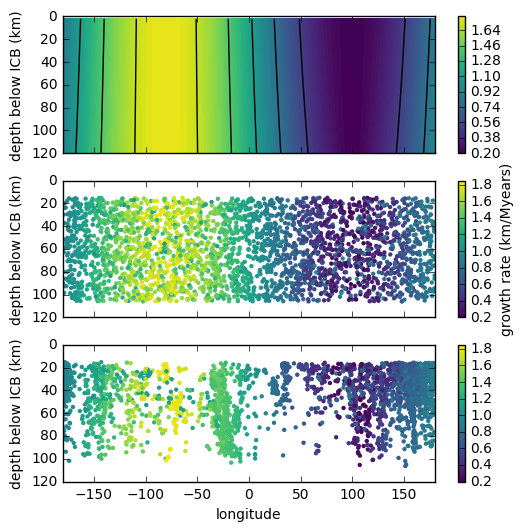

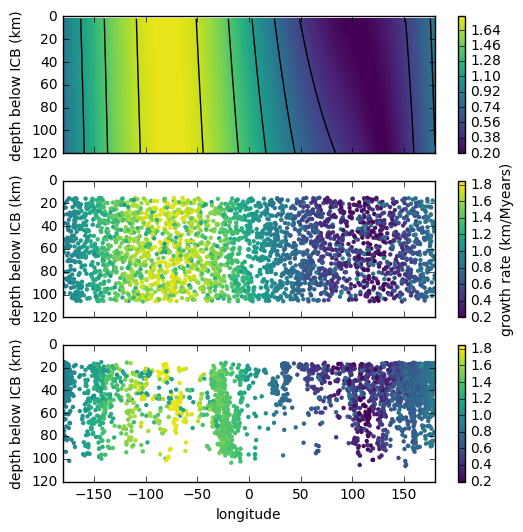

In [27]:
## All the figures have the same colormap and values of colors. But the contourf colorbar are not well designed. 

fig, ax = plt.subplots(3,1,figsize=(6, 6), sharex=True)

r, t, p = data_set.extract_rtp("bottom_turning_point")
#fig, ax = plt.subplots(figsize=(8, 2))
sc=ax[2].scatter(p,rICB_dim*(1.-r), c=proxy1, s=10,cmap=cm, linewidth=0, vmin=proxy_lim[0], vmax=proxy_lim[1])
ax[2].set_ylim(-0,120)
ax[2].invert_yaxis()
ax[2].set_xlim(-180,180)
cbar = fig.colorbar(sc,ax=ax[2])
ax[2].set_xlabel("longitude")
ax[2].set_ylabel("depth below ICB (km)")
#cbar.set_label(proxy_name)

r, t, p = data_set_random.extract_rtp("bottom_turning_point")
#fig, ax = plt.subplots(figsize=(8, 2))
sc=ax[1].scatter(p,rICB_dim*(1.-r), c=proxy_random1, s=10,cmap=cm, linewidth=0, vmin=proxy_lim[0], vmax=proxy_lim[1])
ax[1].set_ylim(-0,120)
ax[1].invert_yaxis()
ax[1].set_xlim(-180,180)
cbar = fig.colorbar(sc,ax=ax[1])
ax[1].set_ylabel("depth below ICB (km)")
cbar.set_label(proxy_name)

#fig3, ax3 = plt.subplots(figsize=(8, 2))
X, Y, Z  = data_meshgrid.mesh_RPProxy(proxy_meshgrid1)
sc = ax[0].contourf(Y, rICB_dim*(1.-X), Z, 100, cmap=cm, vmin=proxy_lim[0], vmax=proxy_lim[1])
sc2 = ax[0].contour(sc, levels=sc.levels[::15], colors = "k")
ax[0].set_ylim(-0, 120)
ax[0].invert_yaxis()
ax[0].set_xlim(-180,180)
cbar = fig3.colorbar(sc,ax=ax[0])
#cbar.set_label(proxy_name)
ax[0].set_ylabel("depth below ICB (km)")

plt.savefig("Fig4_1.pdf")


fig, ax = plt.subplots(3,1,figsize=(6, 6), sharex=True)

r, t, p = data_set.extract_rtp("bottom_turning_point")
#fig, ax = plt.subplots(figsize=(8, 2))
sc=ax[2].scatter(p,rICB_dim*(1.-r), c=proxy2, s=10,cmap=cm, linewidth=0, vmin=proxy_lim[0], vmax=proxy_lim[1])
ax[2].set_ylim(-0,120)
ax[2].invert_yaxis()
ax[2].set_xlim(-180,180)
cbar = fig.colorbar(sc,ax=ax[2])
ax[2].set_xlabel("longitude")
ax[2].set_ylabel("depth below ICB (km)")
#cbar.set_label(proxy_name)

r, t, p = data_set_random.extract_rtp("bottom_turning_point")
#fig, ax = plt.subplots(figsize=(8, 2))
sc=ax[1].scatter(p,rICB_dim*(1.-r), c=proxy_random2, s=10,cmap=cm, linewidth=0, vmin=proxy_lim[0], vmax=proxy_lim[1])
ax[1].set_ylim(-0,120)
ax[1].invert_yaxis()
ax[1].set_xlim(-180,180)
cbar = fig.colorbar(sc,ax=ax[1])
ax[1].set_ylabel("depth below ICB (km)")
cbar.set_label(proxy_name)

#fig3, ax3 = plt.subplots(figsize=(8, 2))
X, Y, Z  = data_meshgrid.mesh_RPProxy(proxy_meshgrid2)
sc = ax[0].contourf(Y, rICB_dim*(1.-X), Z, 100, cmap=cm, vmin=proxy_lim[0], vmax=proxy_lim[1])
sc2 = ax[0].contour(sc, levels=sc.levels[::15], colors = "k")
ax[0].set_ylim(-0, 120)
ax[0].invert_yaxis()
ax[0].set_xlim(-180,180)
cbar = fig.colorbar(sc, ax=ax[0])
#cbar.set_label(proxy_name)
ax[0].set_ylabel("depth below ICB (km)")
plt.savefig("Fig4_2.pdf")


In [30]:
print((sum(proxy_random1-proxy_random2)))

-9.5117403764
